#Proyecto Data Science - Parte I: Análisis operativo en Contact Center     

## Abstract

El presente proyecto enfoca su análisis en un dataset anonimizado de las llamadas que ingresan (inbound) al Contact Center de una empresa de Seguridad, Videovigilancia y Control de Acceso.

El equipo de trabajo de Accesos divide su operativa en cuatro turnos que cambia cada seis horas (Madrugada: 00:00 - 05:59; Mañana: 06:00 - 11:59; Tarde: 12:00 - 17:59; Noche: 18:00 - 23:59). Esto implica que la mayoría de los operadores trabaja jornadas de seis horas, y unos pocos de cuatro horas.

El dataset originado de la plataforma de gestión de llamadas contiene identificadores y nombres anonimizados para los operadores y edificios; fecha y hora de la llamada ocurrida; estado de la llamada (contestada, no contestada); tiempo promedio que transcurre hasta que una llamada es atendida por los operadores una vez ingresan a su interno (ASA, Average Speed Of Answer); tiempo de llamada promedio de los operadores (AHT, Average Handle Time); identificador del operador que atendió la llamada (id_turno, sector al que pertenece y rol que cumple); y tres últimas columnas que marcan SI o NO dependiendo de la naturaleza de la llamada si fuese outbound (si su destino es un intercom, teléfono fijo/celular o un altoparlante o horn utilizado para disuasiones en eventos de seguridad).

A partir de este dataset se busca analizar la relación existente entre el volumen de llamadas y los tiempos de atención (ASA y AHT), así como entender cómo varían estos indicadores en los diferentes turnos de trabajo. Una vez identifiquemos estos patrones de demanda operativa se busca optimizar la gestión de recursos, anticipar cambios en la carga de trabajo y, a raíz de esto, mejorar la calidad del servicio brindado.






      


## Preguntas de interés

1.   ¿La cantidad de llamadas entrantes (inbound) es equivalente entre los diferentes turnos de trabajo?

2.   ¿Existen picos operativos bien marcados dentro de los diferentes turnos y, si es así, presentan similitudes con los picos de otros turnos?

3.   ¿Qué tanto varían estos picos en comparación con la demanda promedio de cada turno?

4.   ¿Es factible definir turnos intermedios o incorporar más operadores de jornadas de cuatro horas para cubrir los picos de una manera más eficiente?
5.   ¿La demanda operativa disminuye durante los fines de semana respecto a los días de la semana?

## Hipótesis de trabajo


*   Hipótesis 1: El volumen de llamadas inbound no es equivalente entre los diferentes turnos. Algunos turnos tienen más demanda operativa que otros.

*   Hipótesis 2: Hay picos operativos claros dentro de cada turno. Estos presentan patrones comparables entre los diferentes turnos.

*   Hipótesis 3: Estos picos aumentarían significativamente la demanda respecto al promedio del turno evaluado.

*   Hipótesis 4: Incorporar más operadores con jornadas de cuatro horas es la mejor alternativa para cubrir estos picos eficientemente.

*   Hipótesis 5: La demanda operativa disminuye significativamente durante los fines de semana en todos los turnos menos en la madrugada.

## Análisis Exploratorio de Datos (EDA)



### Descripción de los tipos de datos

Las columnas que contienen información numérica como 'sonando', 'hablando', 'totales', etc, fueron reconocidos correctamente como int64. A partir de esto fue posible realizar cálculos matemáticos y estadísticos sin inconvenientes. La columna relacionada con fechas y horas como fecha_hora fue convertida a formato datetime64 para facilitar el análisis basado en el tiempo, como cálculos de promedios por hora, dia o mes. Fue de este modo que definimos los cuatro turnos en base a la hora que podemos extraer de fecha_hora usando Pandas. Las columnas que almacenan cadenas de texto como 'intercom' o 'nombre_destino' fueron tratadas como object permitiéndonos realizar manipulaciones cuando fuese necesario.

### Razón para excluir ciertos operadores y registros en los cálculos

Durante el proceso de limpieza y preparación de los datos se excluyeron ciertos operadores y registros que no son de importancia en el presente análisis. Al tener conocimiento de como funciona la plataforma de telecomunicaciones y como estan configurados los operadores sabemos que las llamadas con id_operador <= 1 son de operadores de testeo y un operador para visualizar la cola de llamadas (Q), los cuales no tienen impacto en las mediciones que queremos realizar. A su vez excluímos los operadores con id_turno == 5, ya que estos pertenecen a otro sector y no son el objeto de análisis de este proyecto. Por último excluímos registros de los edificios con id_edificio == 0, ya que referían a comunicaciones dentro de la empresa (por fuera del sector de Accesos) y que no tienen importancia para el presente trabajo.

### Transformación de datos

A fin de realizar un análisis mas efectivo se realizaron diversas transformaciones sobre el dataframe. Una de las principales fue la conversión de la columna fecha_hora, inicialmente en formato object, a un formato datetime. Esto perimitió desglosar fecha_hora en sus componentes individuales usando Pandas, lo que facilitó la segmentación de los datos en horas, dias, turnos para calcular de forma mas precisa el ASA y el AHT. A su vez se crearon nuevas columnas como dia_semana que permite evaluar el comportamiento de las metricas seleccionadas por dia de la semana y detectar asi patrones que puedan llevar a oportunidades de mejora en la operativa.

### Manejo de datos vacíos, nulos y NaN

Una de las primeras decisiones en la limpieza de datos fue el manejo de la columna intercom que contenia 100% de valores nulos. Para evitar que estos valores afectaran cualquier tipo de posterior analisis, se decidió reemplazar los valores nulos por "NO" usando Pandas. Al tener conocimiento del funcionamiento de la plataforma utilizada para gestionar las llamadas es posible decidir esto sin muchos inconvenientes ya que si los registros son para llamadas entrantes todos los valores deben ser NO (estas tres columnas -intercom, fijo_cel, altoparlante) marcan SI solamente en casos de llamadas salientes y no es el objeto de estudio en este proyecto.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el dataset y lo leemos con Pandas para tener una visualización de las primeras 5 filas
df = pd.read_csv('https://raw.githubusercontent.com/raven-flp/proyecto.coder/refs/heads/main/dataset_anonimizado.csv')
df.head()

,id_edificio,id_operador,fecha_hora,nombre_origen,nombre_destino,estado,sonando,hablando,totales,id_turno,sector,rol,intercom,fijo_cel,altoparlante
0,27,1,2025-03-01 0:00:27,001 - Edificio 1 (00001),Operador 1 (10000),contestadas,0,5,0,0,Cola,Cola,NaN,NO,NO
1,27,77,2025-03-01 0:00:27,001 - Edificio 1 (00001),Operador 2 (10001),contestadas,5,14,24,1,Centro Control,Monitoreo,NaN,NO,NO
2,438,1,2025-03-01 0:00:48,002 - Edificio 2 (00002),Operador 1 (10000),contestadas,0,2,0,0,Cola,Cola,NaN,NO,NO
3,438,12,2025-03-01 0:00:48,002 - Edificio 2 (00002),Operador 3 (10002),contestadas,2,16,20,1,Centro Control,Monitoreo,NaN,NO,NO
4,289,1,2025-03-01 0:02:58,003 - Edificio 3 (00003),Operador 1 (10000),contestadas,0,6,0,0,Cola,Cola,NaN,NO,NO


In [3]:
# Visualizamos rapidamente con este análisis exploratorio rapido si tenemos NaN's y los diferentes tipos de datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199110 entries, 0 to 199109
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_edificio     199110 non-null  int64  
 1   id_operador     199110 non-null  int64  
 2   fecha_hora      199110 non-null  object 
 3   nombre_origen   199110 non-null  object 
 4   nombre_destino  199110 non-null  object 
 5   estado          199110 non-null  object 
 6   sonando         199110 non-null  int64  
 7   hablando        199110 non-null  int64  
 8   totales         199110 non-null  int64  
 9   id_turno        199110 non-null  int64  
 10  sector          199110 non-null  object 
 11  rol             199110 non-null  object 
 12  intercom        0 non-null       float64
 13  fijo_cel        199110 non-null  object 
 14  altoparlante    199110 non-null  object 
dtypes: float64(1), int64(6), object(8)
memory usage: 22.8+ MB


In [4]:
# Permite identificar que la columna 'fecha_hora' no esta en formato datetime por lo que no vamos a poder realizar operaciones con ella hasta transformarla.
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])

In [5]:
# Identificamos facilmente que la columna 'intercom' figura totalmente nula por lo que debemos cambiarlo. Elegimos cambiar a 'NO' ya que estamos evaluando llamadas entrantes (inbound) en este análisis
df['intercom'] = df['intercom'].fillna('NO')

# Volvemos a visualizar con db.info si el cambio fue exitoso
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199110 entries, 0 to 199109
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id_edificio     199110 non-null  int64         
 1   id_operador     199110 non-null  int64         
 2   fecha_hora      199110 non-null  datetime64[ns]
 3   nombre_origen   199110 non-null  object        
 4   nombre_destino  199110 non-null  object        
 5   estado          199110 non-null  object        
 6   sonando         199110 non-null  int64         
 7   hablando        199110 non-null  int64         
 8   totales         199110 non-null  int64         
 9   id_turno        199110 non-null  int64         
 10  sector          199110 non-null  object        
 11  rol             199110 non-null  object        
 12  intercom        199110 non-null  object        
 13  fijo_cel        199110 non-null  object        
 14  altoparlante    199110 non-null  obj

In [6]:
# Vamos a visualizar las primeras filas para ver el cambio en 'intercom'
df.head()

,id_edificio,id_operador,fecha_hora,nombre_origen,nombre_destino,estado,sonando,hablando,totales,id_turno,sector,rol,intercom,fijo_cel,altoparlante
0,27,1,2025-03-01 00:00:27,001 - Edificio 1 (00001),Operador 1 (10000),contestadas,0,5,0,0,Cola,Cola,NO,NO,NO
1,27,77,2025-03-01 00:00:27,001 - Edificio 1 (00001),Operador 2 (10001),contestadas,5,14,24,1,Centro Control,Monitoreo,NO,NO,NO
2,438,1,2025-03-01 00:00:48,002 - Edificio 2 (00002),Operador 1 (10000),contestadas,0,2,0,0,Cola,Cola,NO,NO,NO
3,438,12,2025-03-01 00:00:48,002 - Edificio 2 (00002),Operador 3 (10002),contestadas,2,16,20,1,Centro Control,Monitoreo,NO,NO,NO
4,289,1,2025-03-01 00:02:58,003 - Edificio 3 (00003),Operador 1 (10000),contestadas,0,6,0,0,Cola,Cola,NO,NO,NO


## Definición de indicadores y filtro inicial del dataframe

In [7]:
# Tomamos el dataframe total y aplicamos un filtro que necesitamos para calcular correctamente el AHT
filtro_aht = df[(df['id_operador'] >1) & (df['id_turno'] !=5) & (df['id_edificio'] !=0) & (df['estado'] == "contestadas")]

# Tomamos el dataframe total y aplicamos un filtro que necesitamos para calcular correctamente el ASA
filtro_asa = df[(df['id_operador'] >1) & (df['id_turno'] != 5) & (df['id_edificio'] !=0) & (df['estado'] == "contestadas")]

# Calculo del AHT
aht = filtro_aht['hablando'].mean()

#Calculo del ASA
asa = filtro_asa['sonando'].mean()

print(f"Valor del AHT(seg): {aht}")
print(f"Valor del ASA(seg): {asa}")

# Aquí aprovechamos el filtro que aplicamos al AHT o al ASA para saber la cantidad de filas del dataframe y nos sirve como herramienta para contar las llamadas en ese periodo
print(f"Total de llamadas: {filtro_aht.shape[0]}")

Valor del AHT(seg): 27.13657639942719
Valor del ASA(seg): 1.7126659114711351
Total de llamadas: 93574


In [8]:
# Para poder calcular correctamente los indicadores en el tiempo y realizar comparaciones debemos crear una columna con el dia de la semana y otra con la hora para afinar el análisis.

df['dia_semana'] = df['fecha_hora'].dt.day_name()
df['hora'] = df['fecha_hora'].dt.hour

In [9]:
# Ahora debemos usar la columna fecha_hora para definir en que turno ocurrió cada llamada en nuestro dataframe

def asignacion_turno(hora):
  if 0 <= hora <6:
    return 'Madrugada'
  elif 6 <= hora < 12:
    return 'Mañana'
  elif 12 <= hora < 18:
    return 'Tarde'
  else:
    return 'Noche'

df['turno'] = df['fecha_hora'].dt.hour.apply(asignacion_turno)

# Usamos tail para ver los ultimos 5 registros y confirmar que quedo operativa la función

df.tail()

,id_edificio,id_operador,fecha_hora,nombre_origen,nombre_destino,estado,sonando,hablando,totales,id_turno,sector,rol,intercom,fijo_cel,altoparlante,dia_semana,hora,turno
199105,326,65,2025-03-31 23:48:04,474 - Edificio 474 (00474),Operador 28 (10027),contestadas,2,47,51,4,Centro Control,Accesos,NO,NO,NO,Monday,23,Noche
199106,175,1,2025-03-31 23:51:13,652 - Edificio 652 (00652),Operador 1 (10000),contestadas,0,3,0,0,Cola,Cola,NO,NO,NO,Monday,23,Noche
199107,175,65,2025-03-31 23:51:13,652 - Edificio 652 (00652),Operador 28 (10027),contestadas,2,10,15,4,Centro Control,Accesos,NO,NO,NO,Monday,23,Noche
199108,164,1,2025-03-31 23:51:22,553 - Edificio 553 (00553),Operador 1 (10000),contestadas,0,3,0,0,Cola,Cola,NO,NO,NO,Monday,23,Noche
199109,164,58,2025-03-31 23:51:22,553 - Edificio 553 (00553),Operador 27 (10026),contestadas,3,13,19,4,Centro Control,Accesos,NO,NO,NO,Monday,23,Noche


## Visualizaciones

### Visualización de indicadores filtrando por turno usando Seaborn

In [37]:
# Ahora deberiamos poder usar los indicadores AHT, ASA y cantidad de llamadas y agrupar por Turno. Para eso crearemos un filtro general que usaremos para los indicadores ya que anteriormente lo hicimos para probar el calculo y ahora usaremos este filtro para todos.

df_filtrado = df[(df['id_operador'] >1) & (df['id_turno'] !=5) & (df['id_edificio'] !=0) & (df['estado'] == "contestadas")].copy()

# Agruparemos por turno

resumen_turnos = df_filtrado.groupby('turno').agg({
    'hablando' : 'mean',
    'sonando' : 'mean',
    'nombre_destino' : 'count'
    }).rename(columns={
    'hablando' : 'AHT',
    'sonando' : 'ASA',
    'nombre_destino' : 'Cantidad de llamadas'})

print(resumen_turnos)


                 AHT       ASA  Cantidad de llamadas
turno                                               
Madrugada  23.348647  2.933048                  2808
Mañana     27.354986  1.759975                 25139
Noche      25.335270  1.370457                 27709
Tarde      28.588612  1.840999                 37918


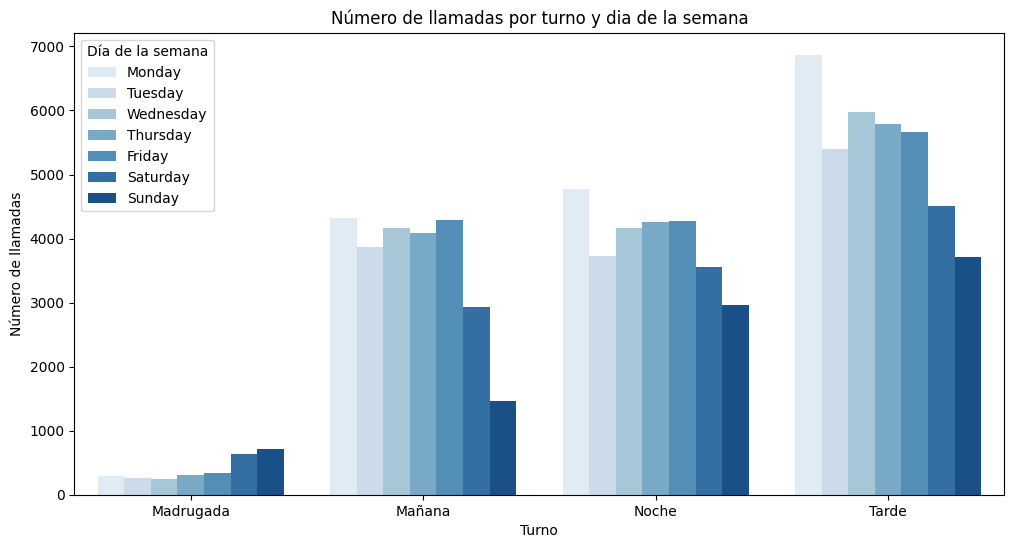

In [38]:
# Primero vamos a asegurarnos de que dia_semana este categorica y tenga un orden para visualizar los dias en el orden correcto

dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_filtrado['dia_semana'] = pd.Categorical(df_filtrado['dia_semana'], categories=dias_orden, ordered=True)

# Ahora que tenemos las columnas que necesitamos vamos a agrupar por turno y dia de la semana para poder visualizar la cantidad de llamadas por turno y por dia de la semana.

llamadas_turno_dia = df_filtrado.groupby(['turno', 'dia_semana'], observed=False).size().reset_index(name='Cantidad de llamadas')

# Grafiquemos usando Seaborn

plt.figure(figsize=(12, 6))
sns.barplot(x='turno', y='Cantidad de llamadas', hue='dia_semana', palette = "Blues", data=llamadas_turno_dia)
plt.title('Número de llamadas por turno y dia de la semana')
plt.xlabel('Turno')
plt.ylabel('Número de llamadas')
plt.legend(title='Día de la semana')
plt.show()

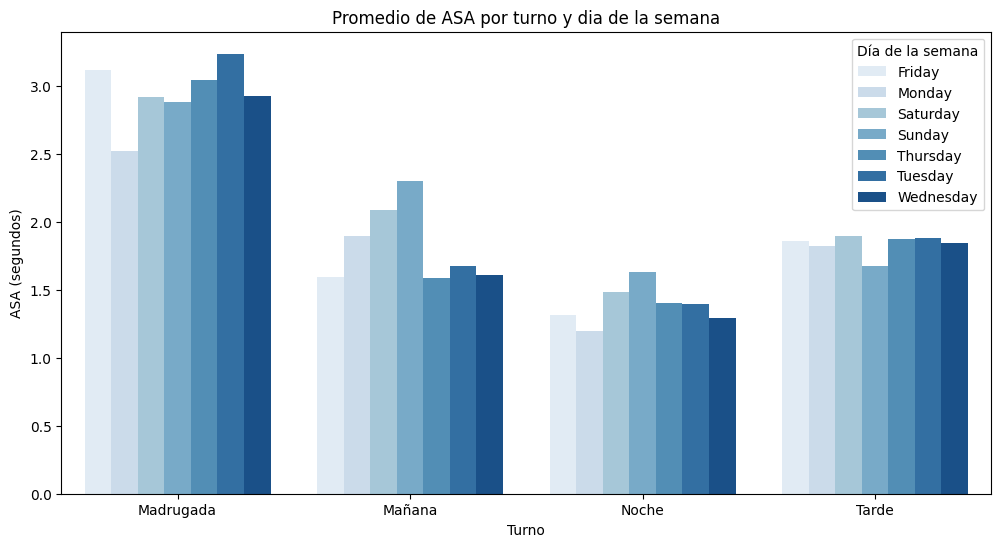

In [25]:
# Ahora vamos a graficar usando esta agrupacion de turnos y dias de la semana para visualizar el AHT y el ASA

asa_turno_dia = df_filtrado.groupby(['turno', 'dia_semana'], observed=False)['sonando'].mean().reset_index(name='Average Speed of Answer - ASA')

# Grafiquemos usando Seaborn

plt.figure(figsize=(12, 6))
sns.barplot(x='turno', y='Average Speed of Answer - ASA', hue='dia_semana', palette = "Blues", data=asa_turno_dia)
plt.title('Promedio de ASA por turno y dia de la semana')
plt.xlabel('Turno')
plt.ylabel('ASA (segundos)')
plt.legend(title='Día de la semana')
plt.show()

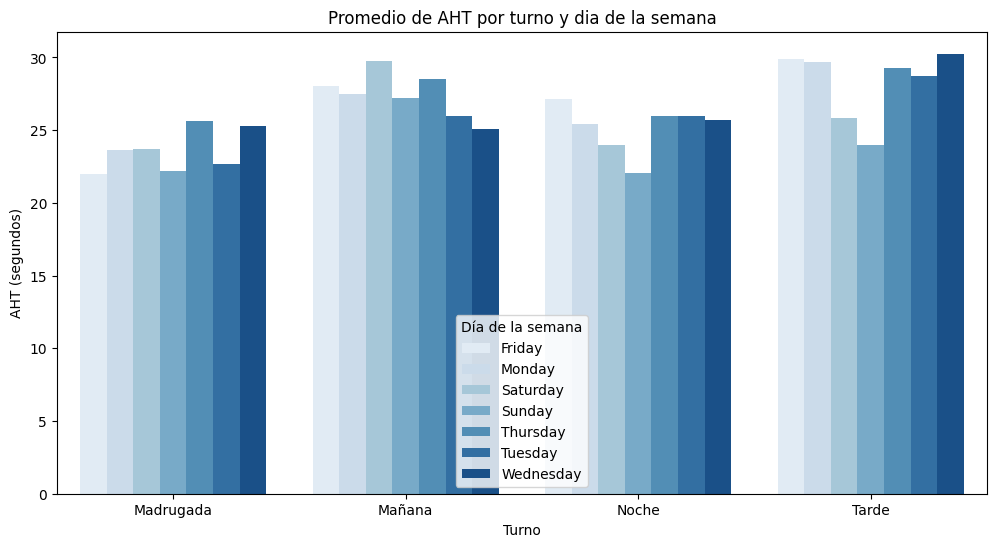

In [26]:
aht_turno_dia = df_filtrado.groupby(['turno', 'dia_semana'], observed=False)['hablando'].mean().reset_index(name='Average Handle Time - AHT')

# Grafiquemos usando Seaborn

plt.figure(figsize=(12, 6))
sns.barplot(x='turno', y='Average Handle Time - AHT', hue='dia_semana', palette = "Blues", data=aht_turno_dia)
plt.title('Promedio de AHT por turno y dia de la semana')
plt.xlabel('Turno')
plt.ylabel('AHT (segundos)')
plt.legend(title='Día de la semana')
plt.show()

### Visualización de indicadores por hora filtrando por turno usando Matplotlib

#### Cantidad de llamadas por turno y por hora

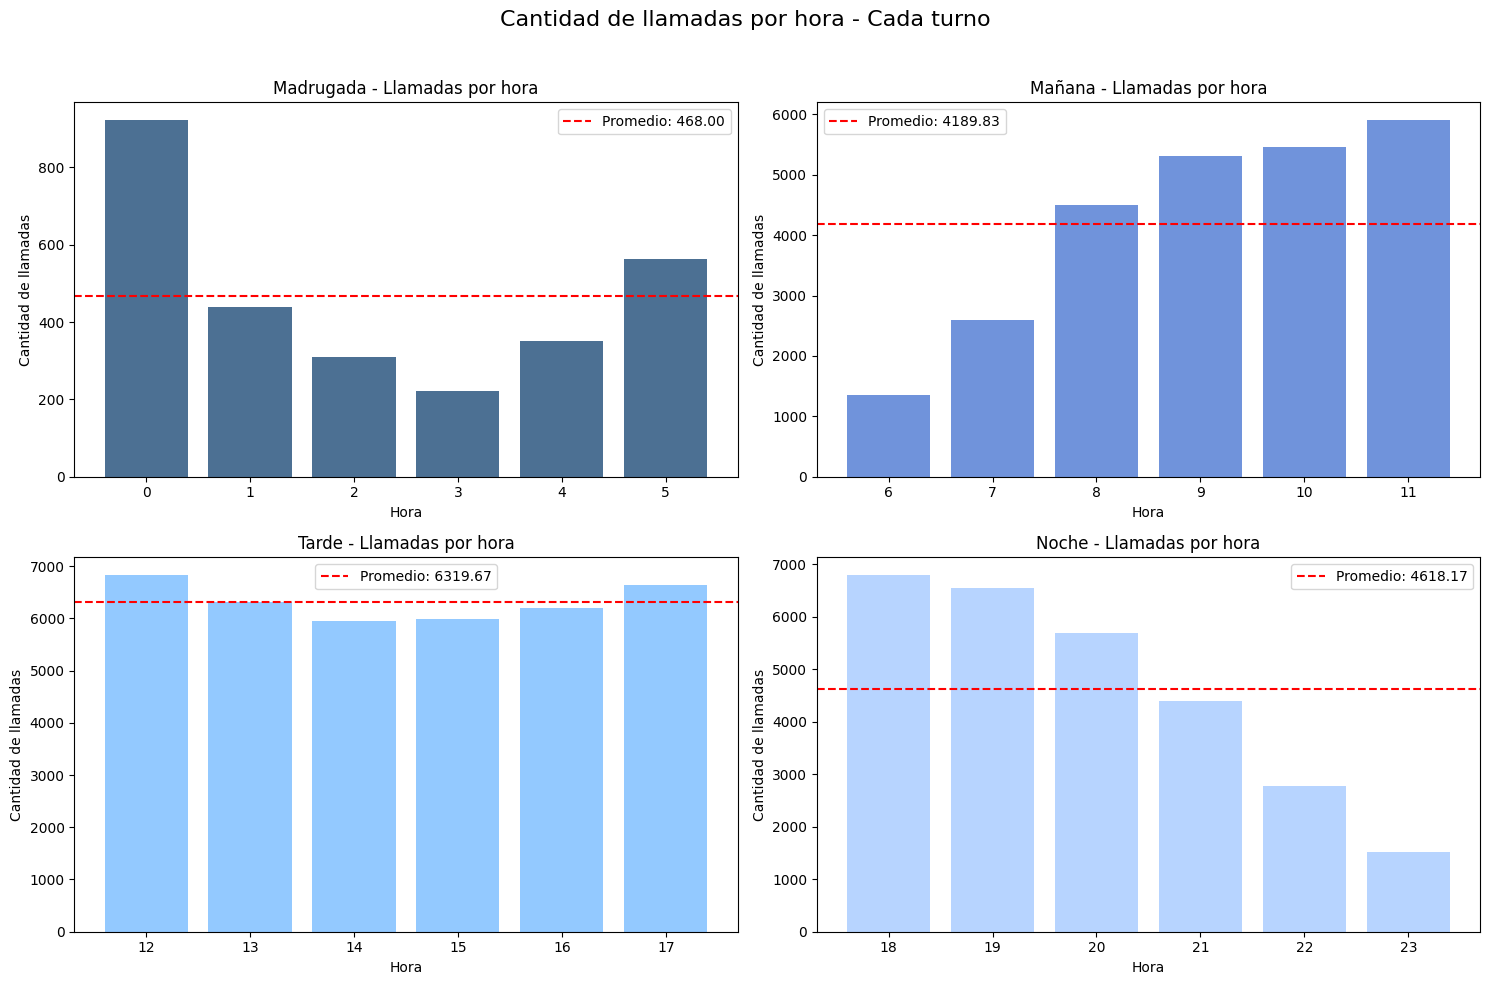

In [32]:
# Como Matplotlib no tiene temas predefinidos como Seaborn vamos a definir los colores con diferentes tonos

colores = {
    'Madrugada': '#003366',
    'Mañana': '#3366cc',
    'Tarde': '#66b3ff',
    'Noche': '#99c2ff'
}

# Crear la figura para la cantidad de llamadas por hora

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cantidad de llamadas por hora - Cada turno', fontsize=16)

# Filtrar los datos por turno

for i, turno in enumerate(['Madrugada', 'Mañana', 'Tarde', 'Noche']):
  df_turno = df_filtrado[df_filtrado['turno'] == turno]
  llamadas_por_hora = df_turno.groupby(df_turno['fecha_hora'].dt.hour).size()

  ax = axes[i // 2, i % 2]

  ax.bar(llamadas_por_hora.index, llamadas_por_hora.values, alpha=0.7, color=colores[turno])

  promedio = llamadas_por_hora.mean()
  ax.axhline(y=promedio, color='r', linestyle='--', label=f'Promedio: {promedio:.2f}')
  ax.legend()

  ax.set_title(f'{turno} - Llamadas por hora')
  ax.set_xlabel('Hora')
  ax.set_ylabel('Cantidad de llamadas')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### AHT Promedio por turno y por hora

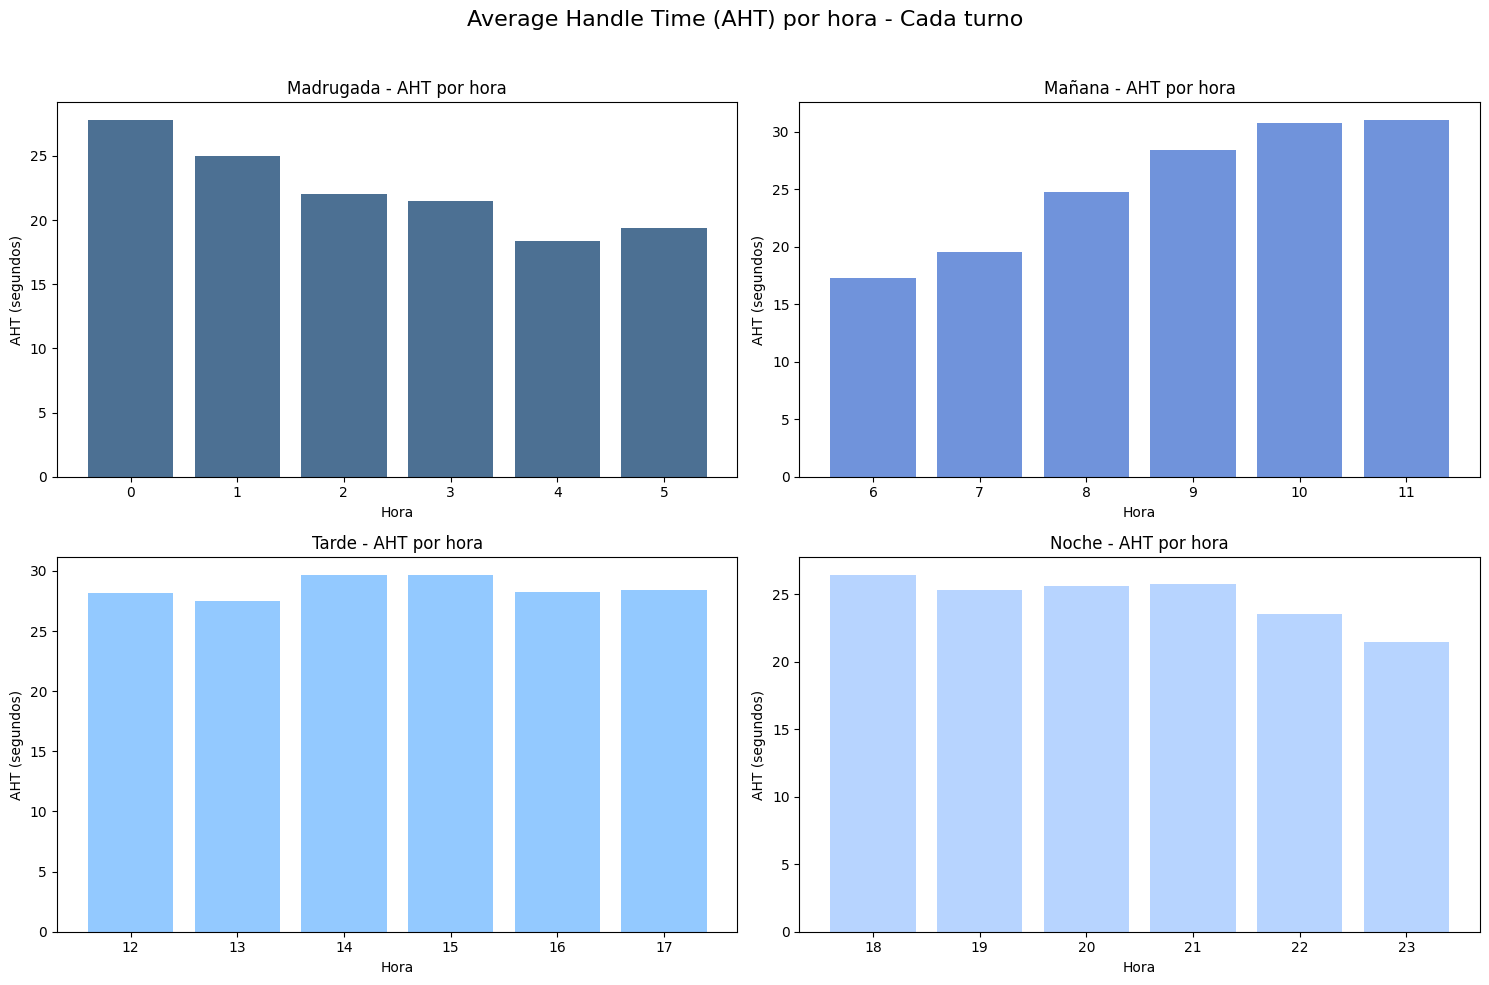

In [29]:
# Crear la figura para el AHT por hora

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Average Handle Time (AHT) por hora - Cada turno', fontsize=16)

# Filtrar los datos por turno

for i, turno in enumerate(['Madrugada', 'Mañana', 'Tarde', 'Noche']):
  df_turno = df_filtrado[df_filtrado['turno'] == turno]
  aht_por_hora = df_turno.groupby(df_turno['fecha_hora'].dt.hour)['hablando'].mean()

  ax = axes[i // 2, i % 2]

  ax.bar(aht_por_hora.index, aht_por_hora.values, alpha=0.7, color=colores[turno])

  ax.set_title(f'{turno} - AHT por hora')
  ax.set_xlabel('Hora')
  ax.set_ylabel('AHT (segundos)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### ASA Promedio por turno y por hora

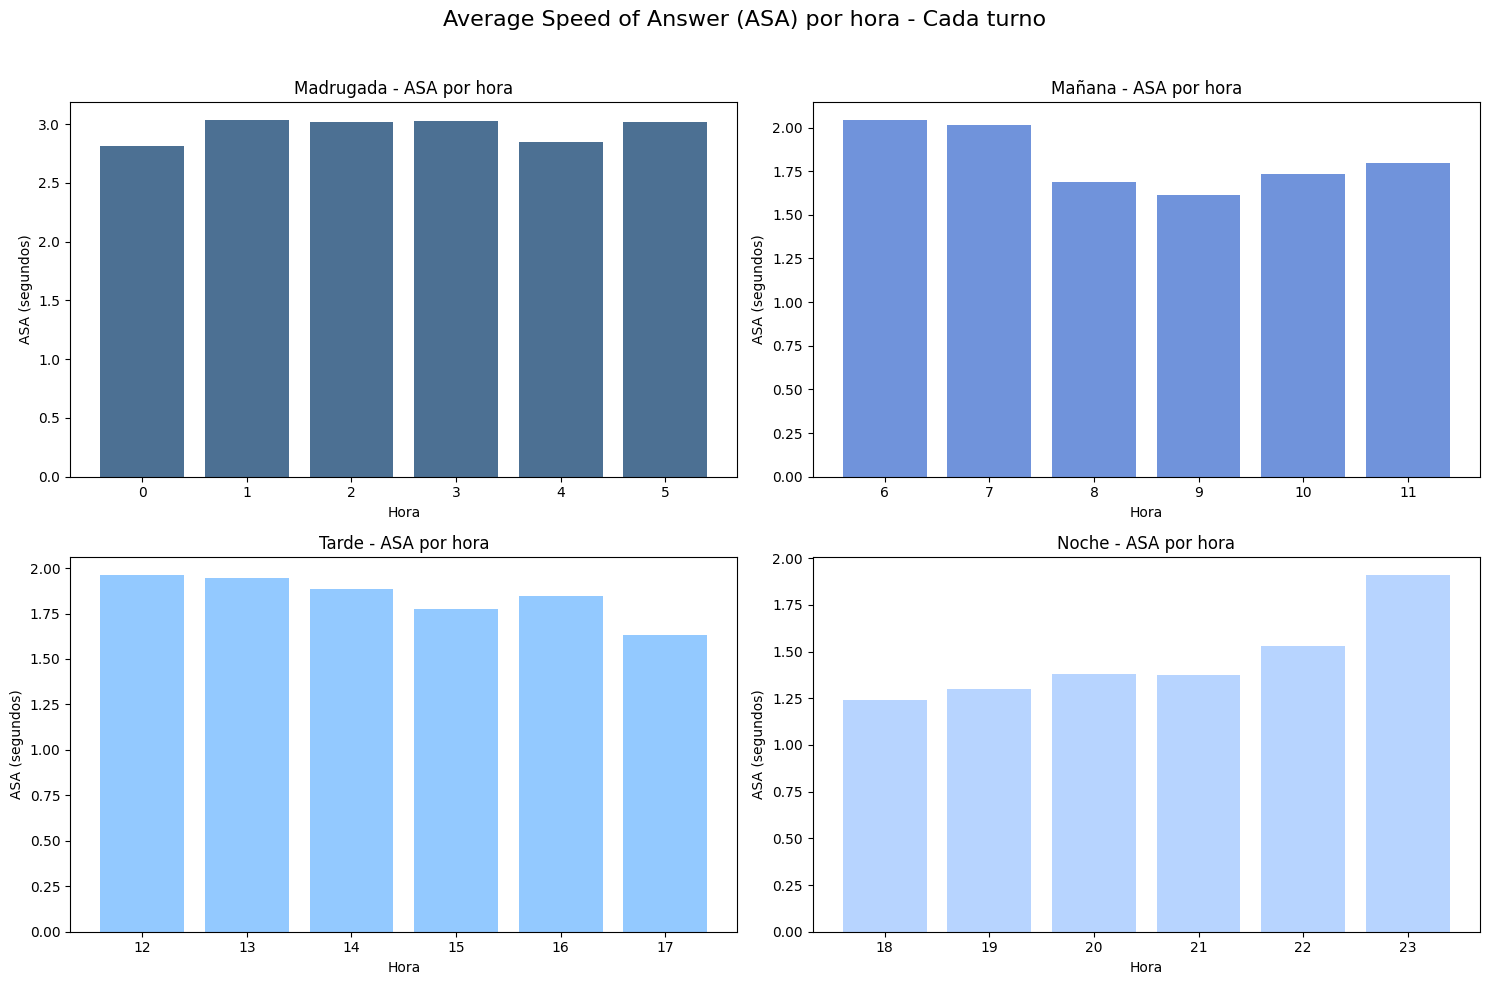

In [30]:
# Crear la figura para el ASA por hora

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Average Speed of Answer (ASA) por hora - Cada turno', fontsize=16)

# Filtrar los datos por turno

for i, turno in enumerate(['Madrugada', 'Mañana', 'Tarde', 'Noche']):
  df_turno = df_filtrado[df_filtrado['turno'] == turno]
  asa_por_hora = df_turno.groupby(df_turno['fecha_hora'].dt.hour)['sonando'].mean()

  ax = axes[i // 2, i % 2]

  ax.bar(asa_por_hora.index, asa_por_hora.values, alpha=0.7, color=colores[turno])

  ax.set_title(f'{turno} - ASA por hora')
  ax.set_xlabel('Hora')
  ax.set_ylabel('ASA (segundos)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Respuestas a las preguntas planteadas:

1.   **¿La cantidad de llamadas entrantes (inbound) es equivalente entre los diferentes turnos de trabajo?**

Para responder esta pregunta medimos la cantidad de llamadas entrantes utilizando el filtro horario creado con Pandas, y de esta manera se pudo graficar e identificar visualmente el volumen de llamadas por turnos a través de (resumen_turnos).

Podemos saber con claridad el volumen total, por turno, por dia y por hora gracias a los diferentes filtros aplicados sobre el dataframe.

2.   **¿Existen picos operativos bien marcados dentro de los diferentes turnos y, si es así, presentan similitudes con los picos de otros turnos?**

Para responder esta pregunta medimos la cantidad de llamadas entrantes aplicando el filtro horario usando dt con Pandas, de esta manera pudimos extraer la hora donde ocurren las llamadas para poder visualizar si esta distribuida de forma uniforme o si hay variaciones con el horario (el dataframe que utilizamos fue (llamadas_por_hora)).

Podemos establecer con claridad en que horas hay una mayor carga operativa sobre las llamadas inbound para cada turno de trabajo. No parece haber similitudes obvias entre los picos de cada turno de trabajo, sino que las llamadas parecen agruparse sobre ciertas horas del día.

3.  **¿Qué tanto varían estos picos en comparación con la demanda promedio de cada turno?**

Para responder esta pregunta creamos la medida (promedio) utilizando .mean en Pandas y asi agregamos al gráfico de llamadas por hora para cada turno, donde podemos visualizar estos picos, una linea con el promedio y que valor tiene para cada turno.

Podemos establecer con claridad para cada equipo cuando ocurren estos picos y que tanto impacto tienen sobre la capacidad de gestion de cada turno.

4.   **¿Es factible definir turnos intermedios o incorporar más operadores de jornadas de cuatro horas para cubrir los picos de una manera más eficiente?**

Para responder esta pregunta debemos estudiar la distribución de las llamadas por hora para los operadores, como hicimos al estudiar los picos, y buscar si encontramos puntos donde podamos cubrir dos picos conjuntos (como entre el final de la mañana y el comienzo de la tarde).

Podemos establecer con claridad que hay al menos dos puntos de mayor demanda durante el dia y son sobre las 12:00 y sobre las 18:00. Sabiendo esto y teniendo en consideracion que en la mañana podemos ver poco volumen de llamadas al principio de la jornada que incorporar un operador de cuatro horas que cubra desde las 08:00 hasta las 12:00 sería de gran utilidad para el equipo y un mejor manejo de los recursos. Así como que operadores de cuatro horas en la noche sobre las 18:00 hasta las 22:00 tambien serían de gran utilidad para el equipo. Turnos intermedios por el momento no se identifican con claridad ya que para el turno de la tarde es mejor contar con operadores toda la jornada de seis horas debido a la distribución uniforma de las llamadas durante el turno.

5.   **¿La demanda operativa disminuye durante los fines de semana respecto a los días de la semana?**

Para responder esta pregunta utilizamos las visualizaciones creadas utilizando los filtros sobre el dataframe para visualizar el volumen para cada turno pero agrupado por el dia de la semana. Esto permite distringuir facilmente que días de la semana ven el mayor volumen y que días el menor.

Podemos establecer con claridad que tanto en la mañana como en la tarde el volúmen de llamadas disminuye significativamente en relación al volumén durante la semana; así como podemos establecer que el turno de la madrugada ve su mayor volumen de llamadas durante los fines de semana y el turno de la noche lo ve disminuido pero en mucho menor medida que la mañana y la tarde.


## Evaluación de hipótesis planteadas:

*   **Hipótesis 1: El volumen de llamadas inbound no es equivalente entre los diferentes turnos. Algunos turnos tienen más demanda operativa que otros.**

Se pudieron identificar muy facilmente las diferencias que existen entre las cargas operativas de cada turno, validando la hipótesis planteada con los resultados.

Asi se pudo establecer un orden en base a esta carga operativa donde el turno de la madrugada gestiono 2808 llamadas en el mes; el turno de la mañana 21139 llamadas en el mes; el turno de la noche 27709 llamadas en el mes; el turno de la tarde 37918 llamadas en el mes.

*   **Hipótesis 2: Hay picos operativos claros dentro de cada turno. Estos presentan patrones comparables entre los diferentes turnos.**

Se pudo establecer con claridad la distribución de la cantidad de llamadas en relación con la hora del día donde ocurren las mismas. Si dividimos la hipótesis en dos partes podemos decir que la evidencia valida la primer parte parcialmente (existen claros picos operativos, aunque no en todos los turnos) pero no es posible identificar relaciones comparables entre los diferentes turnos.

*En el turno de la madrugada podemos identificar que la gran mayoría de las llamadas ingresan en el período desde las 00:00 hasta las 00:59, seguido en segundo lugar por el período comprendido desde las 05:00 hasta las 05:59 aunque en este caso el volumen es aproximadamente la mitad del periodo inicial.*

*En el turno de la mañana podemos identificar que hay un aumento pronunciado a partir del período que inicia a las 08:00 y tiene su mayor valor sobre el final del turno.*

*En el turno de la tarde podemos identificar que el pico con el que finaliza la mañana su turno se continúa en la tarde, hasta el período de 12:00 hasta 12:59. De todas modos el turno de la tarde no tiene grandes variaciones en su volúmen de llamadas por hora por lo que los picos no tienen tanta importancia a nivel operativo, pero si pueden ser atendidos de forma mas eficiente.*

*En el turno de la noche podemos identificar que el pico inicial de la tarde es comparable con el periodo desde 18:00 hasta 18:59 y luego va decreciendo hasta tener su menor valor en el periodo final del turno.*

*   **Hipótesis 3: Estos picos aumentarían significativamente la demanda respecto al promedio del turno evaluado.**

Al poder graficar el volumen inbound por turno, y agrupar estas llamadas por hora se puede identificar claramente cuando ocurren y que tanto varían respecto del promedio del turno evaluado. Se puede visualizar facilmente que la madrugada ve aumentada su capacidad de gestion por encima del doble del promedio; el turno de la mañana ve picos por encima de su promedio en 1/3 aproximadamente; el turno de la tarde no tiene picos definidos su distribución es mayormente similar sobre las diferentes horas del turno; el turno de la noche ve picos por encima de su promedio en un 1/3 aproximadamente, de forma muy similar a la mañana pero ocurren al principio del turno y no al final.

Podemos decir que la hipotesis se vio validada por la evidencia parcialmente ya que no todos los turnos tienen picos que aumenten significativamente la demanda respecto al promedio.

*   **Hipótesis 4: Incorporar más operadores con jornadas de cuatro horas es la mejor alternativa para cubrir estos picos eficientemente.**

Al poder visualizar el volumen inbound por turno y agruparlas por hora como se hizo para identificar los picos, podemos determinar que hay momentos clave en el dia que deben cubrirse con especial atención. Se pudo determinar con claridad que los operadores de jornadas de cuatro horas son muy utiles para tratar exculsivamente con los picos en la demanda del sector de manera eficiente por lo que podemos afirmar que la evidencia valida la hipótesis.

*   **Hipótesis 5: La demanda operativa disminuye significativamente durante los fines de semana en todos los turnos menos en la madrugada.**

Al poder graficar y visualizar facilmente el volumen inbound por turno y agruparlo por el dia de la semana, se detectó con claridad que hay un patrón a la baja del volúmen de llamadas durante los fines de semana. Esto es cierto para todos los turnos menos para la madrugada como establecía la hipótesis pero no permite validarla ya que es categórico determinar que es de forma significativa en todos los turnos menos en la madrugad y luego la evidencia demuestra que el turno de la noche no tiene una disminución significativa sino que es menor pero no significativamente menor como ocurre con la mañana y la tarde.





## Conclusiones e insights

A partir del análisis de los diferentes indicadores, pudimos confirmar que existen diferencias claras en el volumen de trabajo entre los distintos turnos. También identificamos patrones consistentes por día de la semana y por hora dentro de cada turno, reflejando dinámicas específicas de cada equipo de trabajo.

Detectamos que el uso de operadores en jornadas de cuatro horas resulta altamente eficiente para cubrir los picos de actividad. En el turno de la mañana, estas jornadas optimizan la cobertura en las horas finales del turno, mientras que en el turno de la noche, lo hacen en las primeras horas del mismo.

En cuanto a la planificación de personal, observamos que es fundamental contar con operadores disponibles durante los fines de semana para cubrir tanto el turno de la madrugada como el de la noche, donde la demanda se mantiene elevada, o no disminuye significativamente. Por otro lado, recomendamos evitar la asignación de operadores para el área de "Accesos" en los turnos de mañana y tarde durante los fines de semana, debido a la disminución significativa en el volumen de trabajo detectado en esos períodos.